<a href="https://colab.research.google.com/github/zoegarm/Creando-Textos-con-DL/blob/main/Proyecto_LSTM_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM: 


## La importancia de predecir una secuencia:

### Objetivo: 

El objetivo de mi máquia es poder **generar** nuevos textos a partir de un estilo dado, en mi caso el estilo está dado por novelas de Juan Rulfo, conocido por su novela Pedro Páramo y El Llano en Llamas. 

Mi máquina tiene un solo objetivo y es aprender la forma en que dado una oración digamos '`si algún\t`' pueda predecir el siguiente caracter de la secuencia, de manera muy burda ejemplifiquemos esto con la siguiente línea: 

`si algún d` 

y posteriormente 
`si algún dí` 

hasta finalizar con 

`si algún día`.

La salida que tenemos es en consecuencia una sentencia de palabras que tiene (o no) coherencia. Esta dependerá de 

1. Las épocas de entrenamiento del algoritmo.
2. La temperatura con la cuál se realizan las predicciones. 
3. La limpieza de los datos o inputs, con los cuales se entrena la red.

Los datos fueron recopilados a partir de las siguientes página: https://albalearning.com y https://www.literatura.us/ , las cuales cuentan con un gran acervo de cuentos, poemas y novelas cortas de diversos autores.


In [ ]:
import tensorflow as tf


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Input, Flatten, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.utils import plot_model

import numpy as np
import os

import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from time import time 

sns.set_style('darkgrid')

## Análisis de Datos: 

En esta parte analizo los datos con los que cuento y hago un conteo de palabras por cada elemento. :) 

### Importo mis datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import io

path = '/content/drive/MyDrive/TSFCI/Proyecto/Juan Rulfo.txt'
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()
print(len(text))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
310999


In [ ]:
text[0:500]

'en corazón de maría vivían, no hace mucho tiempo, un padre y un hijo conocidos como los eremites; si acaso, porque los dos se llamaban euremios. uno, euremio cedillo; otro, euremio cedillo también, aunque no costaba ningún trabajo distinguirlos, ya que uno le sacaba al otro una ventaja de veinticinco años bien colmados.\n         lo colmado estaba en lo alto y garrudo de que lo había dotado la benevolencia de dios nuestro señor al euremio grande. en cambio al chico lo había hecho todo alrevesado,'

Hago un análisis rápido:

In [ ]:
from nltk.util import ngrams
import re
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#los limpio para el análisis: 

#con split no me devuelve el número de espacios ni tampoco los saltos de línea
#me veo forzado a usar comprensión de lista: 

text_copy = text

analisis = [i for i in text]
palabras = text_copy.split()

freq_dist_charact = nltk.FreqDist(text_copy)

print('los carácteres más comunes son: ', freq_dist_charact.most_common(5))

freq_dist_words = nltk.FreqDist(palabras)

print('las palabras más comunes son: ', freq_dist_words.most_common(5))


los carácteres más comunes son:  [(' ', 67125), ('a', 30034), ('e', 29896), ('o', 22401), ('s', 17496)]
las palabras más comunes son:  [('de', 2331), ('que', 2215), ('y', 1655), ('la', 1551), ('a', 1418)]


In [ ]:
#analizamos el conteo sin palabras conectoras: 

#quito los conectores o stopwords: 

spanish_stop_words = stopwords.words('spanish')

all_words_except_stop_words = [word for word in palabras if word not in spanish_stop_words]

#filtro las palabras:
freq_dist_no_stop = nltk.FreqDist(all_words_except_stop_words)

Número de palabras y Número de carácteres

In [ ]:
#imprimamos las palabras más comunes y el total de palabras: 
print('palabras más comunes: ',freq_dist_no_stop.most_common(10))
print(f'total de palabras: {len(freq_dist_no_stop)}')

#contemos el número de carácteres en el texto: 
chars = sorted(list(set(text_copy)))
print('total chars:', len(chars))

palabras más comunes:  [('si', 329), ('allí', 145), ('.', 123), ('ahora', 106), ('vez', 105), ('aquí', 102), ('así', 101), ('allá', 100), ('después', 98), ('luego', 97)]
total de palabras: 10202
total chars: 59


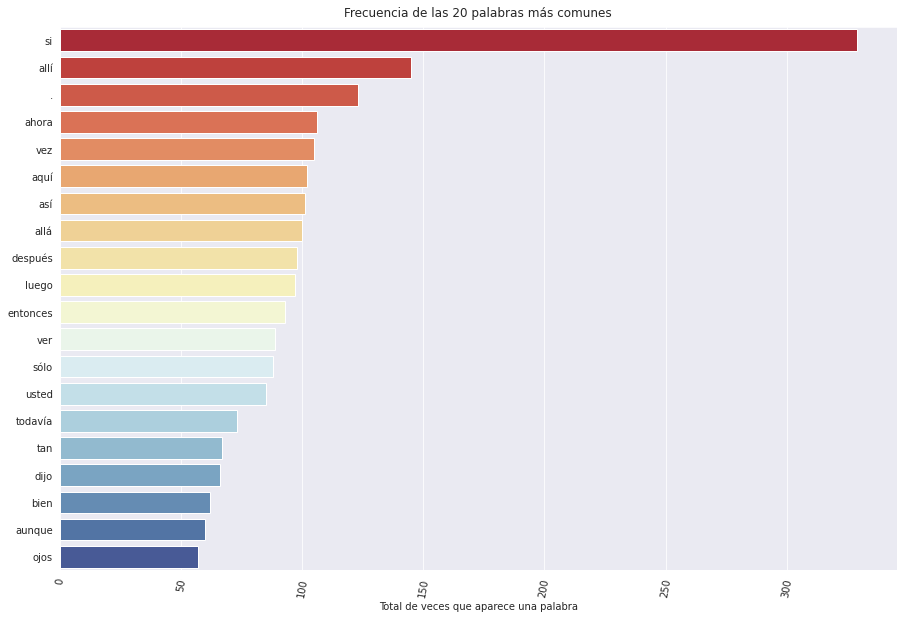

In [ ]:
#creo una visualización de las palabras más comunes: 

most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_no_stop.most_common(20))))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()

sns.barplot(y = most_common_20[:, 0], x = (most_common_20[:, 1]).astype(int), ax=ax, palette='RdYlBu', orient = 'h');
ax.set_title('Frecuencia de las 20 palabras más comunes', pad=10)
ax.set_xlabel('Total de veces que aparece una palabra')
ax.tick_params(axis='x', rotation=80)

plt.show()

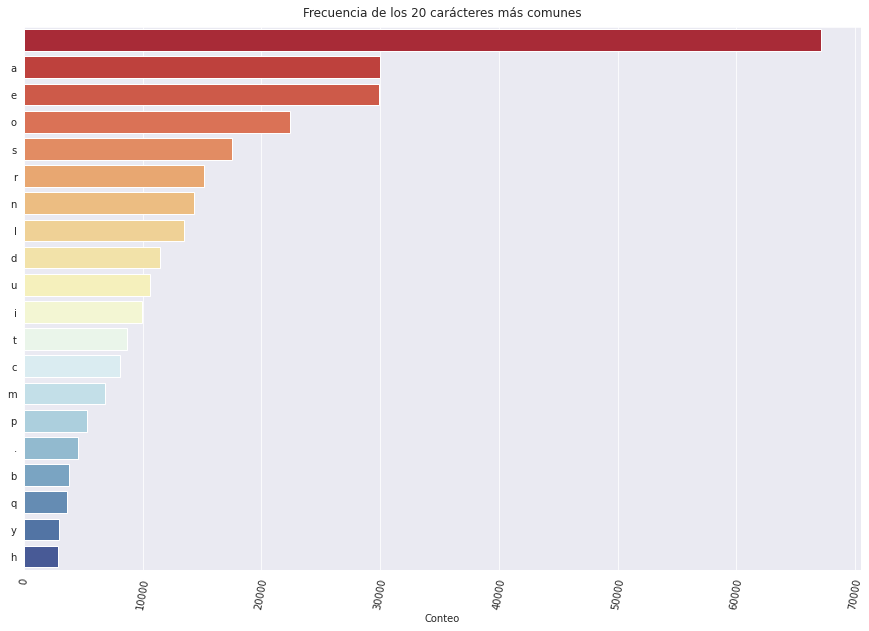

In [ ]:
#Creo una visualización de los caracteres más comunes: 

most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_charact.most_common(20))))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()

sns.barplot(y = most_common_20[:, 0], x = (most_common_20[:, 1]).astype(int), ax=ax, palette='RdYlBu', orient = 'h');
ax.set_title('Frecuencia de los 20 carácteres más comunes', pad=10)
ax.set_xlabel('Conteo')
ax.tick_params(axis='x', rotation=80)

plt.show()

Como podemos ver en mi texto hay muchos carácteres de "espacios", entonces podría ser buena idea remover los saltos de línea para mejorar las predicciones, por ejemplo. Yo sé esto porque yo mismo recopilé la información, pero hacer el análisis me confirma que sí debo quitarlos para mejorar el modelo. Recordemos que el modelo predice tan bien como aprende. Yo tengo el conocimiento de que este conteo tan grande en ese caracter es debido a la naturaleza de la fuente de los datos. 

### Limpieza de Datos

In [ ]:
#Primero quito los saltos, luego divido por carácter y luego dropeo los nan
text_copy_2 = pd.Series(text_copy).str.replace('\n', '').str.split().dropna().sum()

#junto los datos con un conector de espacio
text_copy_2 = ' '.join(text_copy_2)

text_copy = text_copy_2

#obtengo mi data limpia :)
print('la longitud del texto ahora es de', len(text_copy))
print('muestra: \n')
text_copy[0:400]

la longitud del texto ahora es de 297225
muestra: 



'en corazón de maría vivían, no hace mucho tiempo, un padre y un hijo conocidos como los eremites; si acaso, porque los dos se llamaban euremios. uno, euremio cedillo; otro, euremio cedillo también, aunque no costaba ningún trabajo distinguirlos, ya que uno le sacaba al otro una ventaja de veinticinco años bien colmados. lo colmado estaba en lo alto y garrudo de que lo había dotado la benevolencia '

In [ ]:
len(text_copy)

297225

In [ ]:
#analizo nuevamente: 

analisis = [i for i in text_copy]
palabras = text_copy.split()

freq_dist_charact = nltk.FreqDist(text_copy)

print('los carácteres más comunes son: ', freq_dist_charact.most_common(5))

freq_dist_words = nltk.FreqDist(palabras)

print('las palabras más comunes son: ', freq_dist_words.most_common(5))

los carácteres más comunes son:  [(' ', 55152), ('a', 30034), ('e', 29896), ('o', 22401), ('s', 17496)]
las palabras más comunes son:  [('de', 2329), ('que', 2215), ('y', 1655), ('la', 1551), ('a', 1418)]


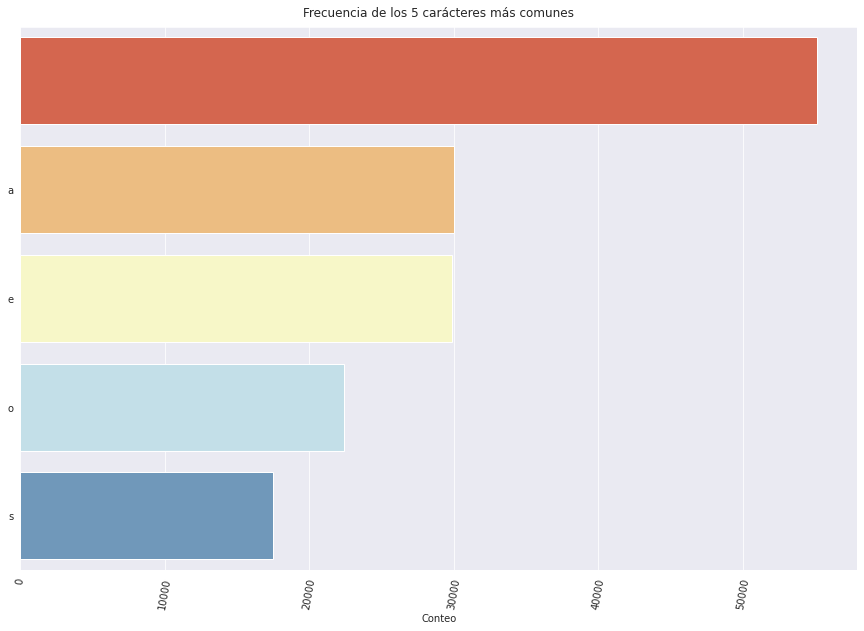

In [ ]:
#Creo una visualización de los caracteres más comunes: 

most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_charact.most_common(5))))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()

sns.barplot(y = most_common_20[:, 0], x = (most_common_20[:, 1]).astype(int), ax=ax, palette='RdYlBu', orient = 'h');
ax.set_title('Frecuencia de los 5 carácteres más comunes', pad=10)
ax.set_xlabel('Conteo')
ax.tick_params(axis='x', rotation=80)

plt.show()

Podemos ver que el procesamiento me quitó 11973 carácteres de espacios, lo que puede mejorar significativamente el aprendizaje de mi máquina. 

## Separación de los Datos

En mi caso voy a entrenar con **letras**. Sí, con letras. Esto es debido a que tengo un total de 10202 palabras diferentes contenidas en el texto (incluyendo algunos símbolos de puntuación que se colaron). Si quisiera entrenar con esa cantidad de datos, tendría que elegir una cantidad aún mayor de datos, que en mi caso son novelas, para poder entrenar bien mi modelo. Además, dado que intento predecir secuencias, dada una palabra con índice `k` tendría que encontrar las $10202 - k$ posibles combinaciones en que esa palabra puede estar asociada a otras.

De forma semejante, si lo hago para el caso de los carácteres en mi texto, solo tengo $58$ carácteres distintos a través de los cuales se pretenden construir palabras y también oraciones completas. 

Este es el precio a pagar, al menos desde mi punto de vista, ya que aunque el algoritmo aprenda la secuencia para reproducir palabras en secuencia, estas dificilmente puedrán tener sentido o gozar, por otro lado de riqueza contextual.

Algo que debemos notar es que no voy a dar un dataset de entrenamiento y otro de validación, en este caso no estoy buscando una máquina que pueda predecir con exactitud la secuencia de caracteres que van a formar en su conjunto, por ejemplo la novela Pedro Páramo, en contraparte, quiero crear una máquina que minimice la función de costo, donde la función que optimizaremos representa la diferencia promedio entre las distribuciones de probabilidad esperada y la obtenida. De tal manera que debo tener un balance entre una función de costo baja y al mismo tiempo cuidar que mi modelo no aprenda lo suficiente como para que pueda predecir de manera exacta los carácteres que le siguen dada una sentencia. 

In [ ]:
text = text_copy

In [ ]:
#Hago diccionarios útiles para mis datos 
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars)) #diccionario de caracter a indice
indices_char = dict((i, c) for i, c in enumerate(chars)) #de indice a caracter

total chars: 58


In [ ]:
sentences = []
next_chars = []
for i in range(0, len(text) - 40, 3):
    sentences.append(text[i: i + 40]) #listas de longitud 40
    next_chars.append(text[i + 40])   #lista del siguiente caracter en la lista

# otra version de one hot encoding con bool:
x = np.zeros((len(sentences), 40, len(chars)), dtype=np.int)
y = np.zeros((len(sentences), len(chars)), dtype=np.int)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1       #lista que tiene el índice de la sentencia, el índice de caracter en la sentencia y el índice del caracter en el diccionario
    y[i, char_indices[next_chars[i]]] = 1   #lista con índice de sentencia en el diccionario con respecto al siguiente caracter

## Definición de Arquitectura:


En esta parte defino el modelo que uso y explico por qué uso ese modelo. Además afino hiperparámetros a través de un muestreo rándom y finalmente doy la arquitectura que usaré para resolver el problema. Primero explico qué es una red RNN, posteriormente una LSTM. 

### LSTM: ¿Qué es? 

Antes de explicar esta red primero debo comenzar con otra que es muy similar a esta, llamada **RNN** o **Recurent Neural Network**. Que son redes que tienen dos entradas, el dato actual y el estado oculto anterior, además proporcionan dos salidas, la predicción y la actualización del estado oculto $a$. Entonces analiza las entradas $x, a$ y realiza una predicción $y$. 

De forma matemática: 

$$
  f(x, a_{t-1}) \rightarrow (y, a_t)
$$

$$
  a_t=f\left(W_t,a_{t-1},x_n\right)
$$

De forma algorítmica: 

```
   x = a and h = 0
   f(x,h) = (a,next_hidden)
   prev_hidden = next_hidden

   x = a and h = prev_hidden
   f(x,h) = (b,next_hidden)
   prev_hidden = next_hidden

   x = b and h = prev_hidden
   f(x,h) = (c,next_hidden)
   prev_hidden = next_hidden

```

Esto significa que a un paso $t+k$ nuestro estado oculto se desvanece  $a_{t+k} \rightarrow 0$ o aumenta como loca $a_{t+k} \rightarrow \infty$, dependiendo de la función $f$, con la cuál es evaluada. 

En el caso de los algoritmos convencionales se usa $tanh$ para evaluar, esto resulta en que las **RNN** tengan una memoria corta. 

Esto se soluciona con las redes LSTM que están diseñadas para poder cargar 2 estados de actualización, uno oculto $a$ y otro llamado **estado de celda** $c$. 

Esquemáticamente: 


<img src = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/The_LSTM_Cell.svg/1024px-The_LSTM_Cell.svg.png' width='500px'>



### El modelo

In [ ]:
learning_rate = 0.01
opt = keras.optimizers.RMSprop(lr=learning_rate)

model_save = ModelCheckpoint("weights-improvement-{epoch:02d}-{loss:.4f}.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor = 'loss', patience= 5)

#Creates a model given an optimitation function and learning rate
def create_model(learning_rate, opt = opt, drop = 0.0):
  
  model = Sequential()
  model.add(LSTM(128, input_shape=(40, len(chars))))#, return_sequences=True))
  
  model.add(BatchNormalization()) #extra
  model.add(Dropout(drop)) #extra

  model.add(Dense(len(chars), activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

  return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Afinando hiperparámetros

Aclaraciones, aunque intenté hacer la elección del muestreo con un for me di cuenta de que ocupa mucha memoria ram, así como también lo hace usar un muestreo k-folds, así que me tuve que ver forzado a hacerlo a mano.

Como sabemos, elegir hiperparámetros adecuados con el método "grid" es muy tardado, así que eligiré el mejor de 5 testeos rándom. 

https://analyticsindiamag.com/why-is-random-search-better-than-grid-search-for-machine-learning/



```python
### Creo una lista de los hiperparámetros que voy a usar para afinar mi modelo: 

## opt_list: lista de optimizers (reducen la función de costo)
opt_list = [tf.keras.optimizers.Adamax(lr=learning_rate), keras.optimizers.RMSprop(lr=learning_rate)]
## lr_list: lista de learning rate: step size at each iteration while moving toward a minimum of a loss function
lr_list = [0.1, 0.01, 0.001]
## lr_batch: lista de batchs: la forma en la que se da la información de entrenamiento
lr_batch = [2**i for i in range(6, 10)]


random_loss = {}

for i in range(0,10):

  random_opt = random.choice(opt_list)
  random_lr = random.choice(lr_list)
  random_batch = random.choice(lr_batch) 
  
  tic = time()

  random_model = create_model(random_lr, random_opt)
  h_random = random_model.fit(x, y, batch_size=random_batch, epochs=5)
  
  toc = time()
  tiempo = toc - tic 
  
  random_loss[i] = [h_random, random_opt, random_lr, random_batch, tiempo]

save = pd.DataFrame(random_loss)

for i in range(0,10):
  save[i][0] = random_loss[i][0].history['loss']

save = save.T.rename(columns={0:'loss', 1:'opt', 2:'lr', 3:'batch', 4:'tiempo'})
save.to_csv('random_loss_7.csv')
```



In [ ]:
# Analizamos los resultados de 70 corridas: 
import warnings
warnings.filterwarnings("ignore")

import ast

dic_df = {}

for i in range(0,7):
  ls_read = pd.read_csv(f'https://raw.githubusercontent.com/zoegarm/Creando-Textos-con-DL/main/hyperparameter_tuning/random_loss_{i+1}.csv', index_col=0)
  dic_df[i] = ls_read

ls_loss = pd.concat(dic_df, ignore_index=True)


for i in range(len(ls_loss)):
  ls_loss.loss[i] = min(ast.literal_eval(ls_loss.loss[i]))


ls_loss = ls_loss.sort_values(['loss','tiempo'], ascending=True)

ls_loss.head()

,loss,opt,lr,batch,tiempo
0,1.77136,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.01,256,43.829839
60,1.77915,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.01,256,53.925647
26,1.77982,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.01,256,31.875779
51,1.78066,<tensorflow.python.keras.optimizer_v2.rmsprop....,0.10,256,84.090773
35,1.78073,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,128,45.080011


````python
#Creo listas para mi adhición de capas y neuronas:
nl_list = [i for i in range(1, 10)]
nn_list = [i**2 for i in range(1, 10)]
list_drop = np.linspace(0, 0.1, 10)

random_loss = {}

for i in range(0, 2):
  random_nl = random.choice(nl_list)
  random_nn = random.choice(nn_list)
  random_drop = random.choice(list_drop)

  print()

  tic = time()

  random_model = create_model(0.01, opt = opt, add = True,
                              nl = random_nl, nn=random_nl, drop=random_drop)
  
  h_random = random_model.fit(x, y, batch_size=random_batch, epochs=5)
  
  toc = time()
  tiempo = toc - tic 

  random_loss[i] = [h_random, tiempo, random_nl, random_nn, random_drop]
````

<img src = 'https://raw.githubusercontent.com/zoegarm/Creando-Textos-con-DL/main/loss_img/loss_vs_e_2.png'>

<img src = 'https://raw.githubusercontent.com/zoegarm/Creando-Textos-con-DL/main/loss_img/loss_vs_e_3.png'>

Drop Out 
```python
#Afino el dropout: 

list_drop = np.linspace(0, 0.1, 10)
loss = {}

for i in range(len(list_drop)):
  
  tic = time()

  random_model = create_model(0.01, opt=opt, drop=list_drop[i])
  h = random_model.fit(x, y, batch_size=256, epochs=10)
  
  toc = time()
  tiempo = toc - tic 
  
  loss[i] = [h, tiempo, list_drop[i]]

save = pd.DataFrame(loss)
save = save.T

plt.figure(figsize=(16, 8))

for i in range(len(save)):
  plt.plot(save[0][i].history['loss'], label = f'drop out: {round(save[2][i], 3)}')
  plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost vs Epoch: No Layers')
```

<img src = "https://raw.githubusercontent.com/zoegarm/Creando-Textos-con-DL/main/loss_img/loss_vs_e_1.png">


**Los mejores hiperparámetros resultan ser el optimizador RMSprop con learning rate de 0.01, con un batch de 0, y ninguna capa extra (ya sea LSTM o multilayer) con respecto al modelo original.**

<img src = 'https://raw.githubusercontent.com/zoegarm/Creando-Textos-con-DL/main/loss_img/loss_vs_e_4_opt.png'>

### Creando el modelo óptimo: 

In [ ]:
model = create_model(0.01, opt=opt, drop = 0)

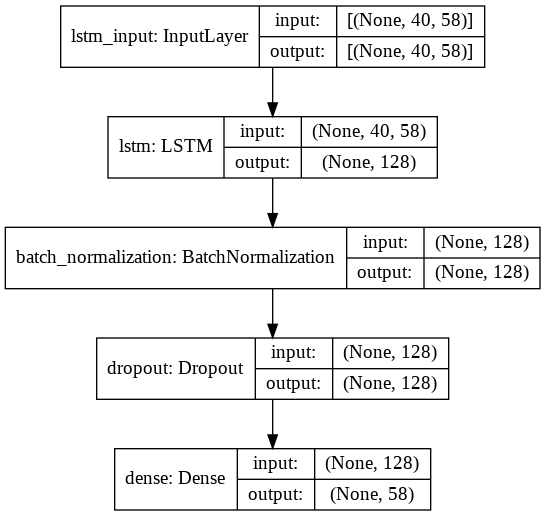

In [ ]:
plot_model(model, show_shapes=True, expand_nested=True, show_layer_names=True)

## Entrenando y haciendo predicciones: 

En esta parte muestro el entrenamiento realizado por mi modelo y posteriormente hago predicciones con respecto a una semilla aleatoria en el texto. Notemos que en principio puede ser cualquier semilla, siempre y cuando esta tenga una longitud de $N$ caracterés dados, que es con la que se realizó el entrenamiento. 

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
#Algunos híperparámetros: 
epochs = 60 #Este hiperparámetro mejora la coherencia del texto obtenido
batch_size = 256 #Tamaño óptimo del batch size

In [ ]:
#entrenamiento
tic = time()
h_call = model.fit(x, y, batch_size=batch_size, epochs=epochs,
                   callbacks = [early_stopping, model_save])
toc = time()

print(toc-tic)

Epoch 1/60
387/387 [==============================] - 3s 9ms/step - loss: 0.8218 - accuracy: 0.7295

Epoch 00001: loss improved from inf to 0.82178, saving model to weights-improvement-01-0.8218.hdf5
Epoch 2/60
387/387 [==============================] - 3s 8ms/step - loss: 0.8189 - accuracy: 0.7301

Epoch 00002: loss improved from 0.82178 to 0.81891, saving model to weights-improvement-02-0.8189.hdf5
Epoch 3/60
387/387 [==============================] - 3s 8ms/step - loss: 0.8179 - accuracy: 0.7293

Epoch 00003: loss improved from 0.81891 to 0.81791, saving model to weights-improvement-03-0.8179.hdf5
Epoch 4/60
387/387 [==============================] - 3s 8ms/step - loss: 0.8195 - accuracy: 0.7279

Epoch 00004: loss did not improve from 0.81791
Epoch 5/60
387/387 [==============================] - 3s 8ms/step - loss: 0.8161 - accuracy: 0.7285

Epoch 00005: loss improved from 0.81791 to 0.81614, saving model to weights-improvement-05-0.8161.hdf5
Epoch 6/60
387/387 [====================

In [ ]:
maxlen = 40 #longitud de los carácteres con los que entrenamos
output_len = 400 #salida máxima del texto, se puede modificar son problemas
temperatura = 0.2 #hiperparámetro que -filtra- la señal de las predicciones una vez realizadas

#elijo un index al azar:
start_index = random.randint(0, len(text) - maxlen - 1)

print(f'**start index: {start_index}**')
print()

generated = "" #string para mis carácteres generados
sentence = text[start_index : start_index + maxlen] #elijo la semilla del texto

print('...Generating with seed: "' + sentence + '"')
print()

for i in range(output_len):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.0 #codifica el mensaje elegido 
    preds = model.predict(x_pred, verbose=0)[0] #lo pasa al predictor y lo predice esto nos regresa una matriz de 1x78
    # print('preds', preds, preds.shape)
    next_index = sample(preds, temperatura) #decodifica la predicción
    # print('next_index', next_index)
    next_char = indices_char[next_index] # obtenemos el caracter
    # print('next_char', next_char)
    sentence = sentence[1:] + next_char #damos el siguiente caracter a la sentencia para seguir en el for loop

    generated += next_char #se lo pegamos a la secuencia que predecimos

print("...Generated: ", generated)
print()

print('...Original: ', text[start_index+40:start_index+400])
print()

**start index: 135798**

...Generating with seed: "tre sueños me acordé de quién era ella. "

...Generated:  yo no se ve a algo aquella perdia por eso es que parecía en el cielo espinador al corral sino por eso pedió la cara lo mirabador la puerta del camino de prisa. para qué viera un pueblo, con la iglesia s como si se estuvo ganado. ellos se dieron por una buena caballos, de otra vez la manos en el cielilo. el oscuera bajar y hacía entretes. en seguido el camino era como tiemposo para eso de la bordad

...Original:  volví a sentir el agua fría de la tormenta que estaba cayendo sobre telcampana, esa noche que entramos allí y arra samos el pueblo. casi estaba seguro de que su padre era aquel viejo al que le dimos su aplaque cuando ya íbamos de salida; al que alguno de nosotros le descerrajó un tiro en la cabeza mientras yo me echaba a su hija sobre la silla del caballo y 



## Los resultados 

Notemos que los datos obtenidos a partir de esta máquina son satisfactorios, pues además de poder predecir el siguiente carácter de una la palabra, con respecto al texto original, también logra aprender un poco acerca de la forma en que las oraciones se forman, aquí unas muestras de lo que es posible obtener con los hiperparámetros seleccionados: 

### Entrenando con 100 épocas, temperatura = 0.07

**start index: 169550**

...Generating with seed: "trás de su madre río abajo. si así fue, "

...Generated:  porque no se puede. s; mel vió a la cosa que no se puede saber de haberse desde acuerdada que yo no se se puede. meevolverá es algo a milar a creces. y de volver a decir la mancha de la noche. está guandroñados, porque yo hay nada. ¿de qué no me mos dí miseto? si oyes. me vi la mara arrayán de mujere. te volvía a nosotros. me acotoló por si no ensentara más pelque yo no se pos su media venir lo ma

...Original:  que dios los ampare a los dos. la apuración que tienen en mi casa es lo que pueda suceder el día de mañana, ahora que mi hermana tacha se quedó sin nada. porque mi papá con muchos trabajos había conseguido a la serpentina, desde que era una vaquilla, para dársela a mi hermana, con el fin de que ella tuviera un capitalito y no se fuera a ir de piruja como lo 

**start index: 183944**

...Generating with seed: " sus trapos a secar. lo vi que temblaba "

...Generated:  la campañarse a la comederada como si se le había de tantar en el sol de mi madrina de todo es que se le va a ni me andará fue que la plate a mi no ha de ningún hinco ni en santario para que se lo había en el pesejo. y de todo es lo que se le acondáramos que se le deban la carab de la berdada de todo la paredo de los compedos y se la volví a term¡arde a saber de mi casa barranca y que siguió mis p

...Original:  de frío. hacía aire y estaba nublado. me estuve asomando desde el boquete de la cerca donde me tenía el patrón al encargo de sus borregos. volvía y miraba a aquel hombre sin que él se maliciara que alguien lo estaba espiando. se apalancó en sus brazos y se estuvo estirando y aflojando su humanidad, dejando orear el cuerpo para que se secara. luego se enjaret

**start index: 33215**

...Generating with seed: "ces que te llamabas? nieves... me sigo l"

...Generated:  o que se le acordarían tan benecién. el comer de la noche. el comprdolo de que no se alimparaba de todo es que se le va a ni me andará fue que la plate a mi no ha de ningún ocamos con hacer a la comedera de la media luna. y lo vi lo mande a la solención al parezo del río y la puede cosa encerra como si se lleva de la noche. sin despertar de todos para ver y sacordar la puede con el conteste que no

...Original:  lamando nieves. nieves garcía. y no me hagas llorar, lucas lucatero. nada más de acordarme de tus melosas promesas me da coraje. nieves... nieves. cómo no me voy a acordar de ti. si eres de lo que no se olvida... eras suavecita. me acuerdo. te siento todavía aquí en mis brazos. suavecita. blanda. el olor del vestido con que salías a verme olía a alcanfor. y 



### Entrenando con 100 épocas temperatura = 0.09

**start index: 224536**

...Generating with seed: "sos días, porque en zapotlán estaban que"

...Generated:   se le parecía en sus ambollos. después singuna toda se sentir que no me llevando a decirles que se le premiró en la media luna más a la cosmiguana. a nada más de todos para ver como si se lo había con un puedena como si se le había de tantar en el costar y son para allá de volver de allí a despertar la mano y con su fristo por que la puerta sueño se fuera de la noche. entonces se le ocurraba la m

...Original:  mando cohetes, mientras que por el rumbo donde tiré a remigio se levantaba una gran parvada de zopilotes a cada tronido que daban los cohetes. de eso me acuerdo. vine a comala porque me dijeron que acá vivía mi padre, un tal pedro páramo. mi madre me lo dijo. y yo le prometí que vendría a verlo en cuanto ella muriera. le apreté sus manos en señal de que lo h

**start index: 147120**

...Generating with seed: "se más malo. llegó un rato en que ya no "

...Generated:  nos traía seguía ospuestado. porque eso ni me a una guandada, sin nosotros que se le debaba en el pueblo. y yo no se supo ni cen, al menos el sol se quedó mi papá la grita grisa. y yo te va a ni sin salto de mi casa apoco, porque en la noche a como si se le había de tantar a la comederando para nosotros ya no se se le ocurría en seguida como si se la buena vez el paredo de la media luna. y lo vi l

...Original:  quería seguir. la carne de sus pies se había reventado y por la reventazón aquella empezó a salírsele la sangre. lo cuidamos hasta que se puso bueno. pero, así y todo, ya no quería seguir: me quedaré aquí sentado un día o dos y luego me volveré a zenzontla. eso nos dijo. pero natalia y yo no quisimos. había algo dentro de nosotros que no nos dejaba sentir ni

**start index: 293481**

...Generating with seed: "quiere que se sepa. ¿ que adónde fue? de"

...Generated:   querirle saber de mi cuballeates. la manco se la parecía de reconocel; la menosiando de su caraba. no se fueran a nadarlas, acabar sus palles, amarrando el río de la media luna. y lo vi lo mande a la secoser que no volvían a despatraban el cuerpo. de su medio y no estaba para no te amarra y yo no se supo ni algún impo muerto es de mi mara de guarda le anguniglas mismo bien de la media luna grando

...Original:   seguro a buscar un becerro cimarrón que anda por ahi desbalagado. al menos eso me dijo. ¿cuánto hace que están ustedes aquí? desde siempre. aquí nacimos. debieron conocer a dolores preciado. tal vez él, donis. yo sé tan poco de la gente. nunca salgo. aquí donde me ve, aquí he estado sempiternamente... bueno, ni tan siempre. sólo desde que él me hizo mujer. 



### Entrenando con 100 épocas, temperatura = 0.1



**start index:  147726**

...Generating with seed: "le deshincharan, le daba ánimos. le decí"

...Generated:  a a la cara la cosa se deshabranda de la misma tara misma...... peíce lo hasta es toda me le pudieron de mi casa, con esos arriban de muchas de mi madrean desde arriba. y lo había dicho: nositas sípanzando hasta la cara de la tierra y les debía a todos de su casa. y eso nos mancha como si se descansada hasta irá por el camino. era estuviera de haber andado esta esta comer. me dije que no se fueran

...Original: ba los pies con aguardiente para que se le deshincharan, le daba ánimos. le decía que sólo la virgen de talpa lo curaría. ella era la única que podía hacer que él se aliviara para siempre. ella nada más. había otras muchas vírgenes; pero sólo la de talpa era la buena. eso le decía natalia. y entonces tanilo se ponía a llorar con lágrimas que hacían surco entre el sudor de su cara y después se maldecía por haber sido malo. natalia le lim

**start index:  34711**

...Generating with seed: "a platicar con ella nomás por pasar el r"

...Generated:  ío y se levanta abajo, la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara la cara l

...Original: i, se fue. la hiciste llorar. sólo quería platicar con ella nomás por pasar el rato. ¿se han fijado cómo tarda en llover? allá en amula ya debe haber llovido, ¿no? si, anteayer cayó un aguacero. no cabe duda de que aquel es un buen sitio. llueve bien y se vive bien. a fe que aquí ni las nubes se aparecen. ¿todavía es rogaciano el presidente municipal? si, todavía. buen hombre ese rogaciano. no. es un maldoso. puede que tengan razón. ¿y 

**start index:  205040**

...Generating with seed: " es que el llano, señor delegado... son "

...Generated:  esperando lo hubiera de haber de haber vendo a la mancha y caminaba de la media la cabal es un modo que le dije: se le había pusidado con sus manos de la cara la cosa se de cara y reconvando de comer para no estar encima de zantlo, con el recorro de la media luna y entretá de la mesa de todo. yo mañana no? porque eso no se digo parecía. yo me llano para eso de verda síque un chacho los costas para

...Original: tener tanto terreno para ustedes solos. es que el llano, señor delegado... son miles y miles de yuntas. pero no hay agua. ni siquiera para hacer un buche hay agua. ¿y el temporal? nadie les dijo que se les iba a dotar con tierras de riego. en cuanto allí llueva, se levantará el maíz como si lo estiraran. pero, señor delegado, la tierra está deslavada, dura. no creemos que el arado se entierre en esa como cantera que es la tierra del ll





### Entrenando con 100 épocas, temperatura = 0.5



**start index:  36011**

...Generating with seed: "erro y desaparecer.¡viejas infelices! ¿y"

...Generated:  a no lo se abajo es sueño de calle salido en un chapallizos en la buena y no se digo nin hasta me dijo. ¿la dinerá no. la mancha comenzó a las falcas a despeés. en ese llegó aguando de comer en mi casa y de todo es pedro zamora, por eso me voy n espertrajió: ¡costemos este llena. hasta no se decía. no pensé que dice? no. no puede se humo. . y allí también, como si sus cosas cuentaates de las pues 

...Original: corral.salirme por la puerta que da al cerro y desaparecer.¡viejas infelices! ¿y qué diantres voy a hacer yo a amula? queremos que nos acompañes en nuestros ruegos. hemos abierto, todas las congregantes del niño anacleto, un novenario de rogaciones para pedir que nos lo canonicen. tú eres su yerno y te necesitamos para que sirvas de testimonio. el señor cura nos encomendó le lleváramos a alguien que lo hubiera tratado de cerca y conocid

**start index:  61929**

...Generating with seed: "rezarse. te llevaré a tonaya. bájame. su"

...Generated:  s no tantando que tiempo se deshabrando que lo días ganas. se le pusba al mismo se les acarraba de mi canció de la mesa saberia de todas para parece hasta allá a decirle que te llevamos con este esperanza.anda para tan triste. y eso pasó. ya. apreví me va a misma resalida en el cerro. no se tenimos me dijo. ¿te pesandes estaría como se les debía con la cara la haber radado de pazcula de la cara la

...Original: dos o tres pasos de lado y volvió a enderezarse. te llevaré a tonaya. bájame. su voz se hizo quedita, apenas murmurada: quiero acostarme un rato. duérmete allí arriba. al cabo te llevo bien agarrado. la luna iba subiendo, casi azul, sobre un cielo claro. la cara del viejo, mojada en sudor, se llenó de luz. escondió los ojos para no mirar de frente, ya que no podía agachar la cabeza agarrotada entre las manos de su hijo. todo esto que ha

**start index:  239746**

...Generating with seed: "puedo alcanzarte ni verte y adonde no ll"

...Generated:  evará pernos conmigo, con eso pasa, mironerondo para todos en el pellen que de el pedazolado estuviera en el cielo. de contra la cara la cara la paredera; pero se la veniran las cosas como si asustó les desha? como es uste. yo teníamos más cosas vez los mandos que está por mi madrinte en canciñada en el cielo. de contra la cambia con tierra... ¡viejas se dejó. nos tenenmes, no parecía mal de la ca

...Original:  s de su divina providencia, donde yo no puedo alcanzarte ni verte y adonde no llegan mis palabras. abuela, el molino no sirve, tiene el gusano roto. esa micaela ha de haber molido molcates en él. no se le quita esa mala costumbre; pero en fin, ya no tiene remedio. ¿ por qué no compramos otro? éste ya de tan viejo ni servía. dices bien. aunque con los gastos que hicimos para enterrar a tu abuelo y los diezmos que le hemos pagado a la igl

**start index: 57551**

...Generating with seed: "ervido haberlos visto. entonces han de h"

...Generated:  aber de haber vendo a apor cómo entrado en el cielo. se manchó con él. no había pasado a la mantarla ese cuando nos dijeron de la penazó para nada. me dijo en el pueblo. me abriento de sí, morirse con el del sol. uste lo hubiera de haber de haber ver aquel cosas pidió de mi cuarto y nos carió por allí no podrá dije: así ve ninuje, anida en la luz. el pasa de caminar. y lo mandó que nos ocupiba en 

...Original:  , paisano’. aunque de nada nos hubiera servido haberlos visto. entonces han de haber sido los apaches. ¿cuáles apaches? pos unos que así les dicen y que viven del otro lado. ¿pos que no están las tejas del otro lado? sí, pero está llena de apaches, como no tienes una idea. les voy a hablar a ojinaga para que recojan a tu amigo y tú prevente pa que regreses a tu tierra. ¿de dónde eres? no debías de haber salido de allá.¿tienes dinero? le





### Entrenando con 100 épocas, temperatura = 0.7


**start index: 205049**

...Generating with seed: "l llano, señor delegado... son miles y m"

...Generated:  al de aldrencho para hacerle carnando la cambia nada de misma..... pedre pel. pero no, pero señor contiándo en un rato. y algo que me del correro. me llevaba un pronto se oían la cara muriera. y el de arriba a mi madre se disvino de contarracirno con el mono del río, y le digo un chupa de pezcallo dice que si a una tambiacida de mediado a pedrerse pinieran. las torme, en este cosa que me está agra

...Original:  el llano, señor delegado... son miles y miles de yuntas. pero no hay agua. ni siquiera para hacer un buche hay agua. ¿y el temporal? nadie les dijo que se les iba a dotar con tierras de riego. en cuanto allí llueva, se levantará el maíz como si lo estiraran. pero, señor delegado, la tierra está deslavada, dura. no creemos que el arado se entierre en esa como cantera que es la tierra del llano. habr

**start index: 161574**

...Generating with seed: "mbién en subir al tapanco, para deshacer"

...Generated:  le que le trató de tristezas y yo no se puede. me debejeos. de eso de uno en mi cuerta de mado de su medio de armibir, a que a mí me deja que no lo voy a dará esfuerzo. por el campestondo sin despertar donde venían mos deja a los lamos si de mis trapas.do de podo el sol, cuando el termando con sus ojicio. la gente nomás sustros. era más pelquita de guardo como una cobija y no nos ramaba un tar all

...Original:  ambién en subir al tapanco, para deshacer la cama donde él y margarita habían pasado la noche. si el señor cura autorizara esto, yo me casaría con ella pero estoy seguro de que armará un escándalo si se lo pido. dirá que es un incesto y nos excomulgará a los dos. más vale dejar las cosas en secreto. en eso iba pensando cuando se encontró al viejo esteban peleándose con el becerro, metiendo sus mano

**start index: 110212**

...Generating with seed: "nta de la hora en que ellos aparecieron "

...Generated:  a la secosa de la orilla, y yo no se acondábamos a nuestros, que se la había nadre. hasta a dar de todo y contesté que eso no le malimaba si silo. y la vi al soldado que no erse ni uno edo caminonado como si oyó del día como si lo hubieran encindo un tejado de morido a salgo de santas como y se nos contaran, pero después de todo para saber de prendizavenir ese desde mirada con mi muy gender con su

...Original:  enta de la hora en que ellos aparecieron por allí. cuando menos acordamos aquí estaban ya, mero enfrente de nosotros, todos desguarnecidos. parecían ir de paso, ajuareados para otros apuros y no para éste de ahorita. nos dimos vuelta y los miramos por la mira de las troneras. pasaron los primeros, luego los segundos y otros más, con el cuerpo echado para adelante, jorobados de sueño. les relumbraba



### Entrenando con 100 épocas, temperatura = 1.2



**start index: 125216**

...Generating with seed: "dministrador y el caporal de la hacienda"

...Generated:   solaban su poco y les digo: sien niman, meevos, apecada? cómo lo llevaba el melilla balpa para de mancla. y el rumbo de los trepando abajor y yo no le gustá resgusto, chimo quedanos trechas bajaba: no me sabía como si fueran sus a uno del quellos ientes. unos últimos con gitar la noche. mi huecengueste que no había sedomate a la noches. el pel simo cobocupadado a miro trancando el día lo lejos cr

...Original:  administrador y el caporal de la hacienda. fueron dos días de toros. tuvimos que hacer un corralito redondo como esos que se usan para encerrar chivas, para que sirviera de plaza. y nosotros nos sentamos sobre las trancas para no dejar salir a los toreros, que corrían muy fuerte en cuanto veían el verduguillo con que los quería cornear pedro zamora. los ocho soldaditos sirvieron para una tarde. los

**start index: 261684**

...Generating with seed: "acias a dios nuestro señor porque se lo "

...Generated:  había carremando la solla el que las encerdades de más allá umo, porque se hita estaba aileron de sueltos; otro largo del zamarecer, el como de lo en embol que me la que me zala y yo llegó de sus muertos tan guyas que le gustaba la seguntina de sentenido. pero no; pero diocí paso ilencio no nos congarna. todos los otros; despertiándose un trapño, earcio, como si se olabía encima como y aunque tení

...Original:  racias a dios nuestro señor porque se lo ha llevado de esta tierra donde causó tanto mal, no importa que ahora lo tenga en su cielo. un caballo pasó al galope donde se cruza la calle real con el camino de contla. nadie lo vio. sin embargo, una mujer que esperaba en las afueras del pueblo contó que había visto el caballo corriendo con las piernas dobladas como si se fuera a ir de bruces. reconoció e

**start index: 118665**

...Generating with seed: " montón de rifles como si fuera una male"

...Generated:  nte como y de sacarlo; la única judada en el ricaso del sol. no existe. sólo estabía estar frente la oía allá de voquilinas. si no le pagé un trombiés en el colerlo . buscando un gajanblaba a llenarte en miedos. y darme y có que lo noche an mi hijo. lo hubiera dor penadarnos, se fueron gritos de pobjarlo. tercios y todavía ciudo el deciénte lo que día por el jur amanero; la llama replatar de fin j

...Original:  n montón de rifles como si fuera una maleta. se apeó del macho. nos repartió las carabinas y volvió a hacer la maleta con las que le sobraban. si no tienen nada urgente que hacer de hoy a mañana, pónganse listos para salir a san buenaventura. allí los está aguardando pedro zamora. en mientras, yo voy un poquito más abajo a buscar a los zanates. luego volveré. al día siguiente volvió, ya de atardeci




## Comentarios

Aunque es verdad que los resultados son satisfactorios, no hace falta mencionar que las palabras formadas en la predicción no tienen mucha coherencia, esto se debe a que el algoritmo no aprende acerca del **contexto de las palabras**, pero sí del **contexto de los carácteres**. Por esto mismo, podemos ver que el algoritmo aprende a formar palabras que tienen sentido dentro de nuestra lengua como `pudieron`, `descansada`, `levanta` y otras que incluso parecen ser palabras verdaderas como `enciñada`, `pesandes` y `madrinte`, esta cualidad lejos de ser vista como un defecto me parece desde otro punto de vista interesante, ¿cómo sabemos que una palabra existe o nos parece familiar sin si quiera saber que existe? 

Para mejorar este algoritmo yo propongo entrar dentro de la estructura de la LSTM y probar distintas configuraciones como la función de activación de la puerta o el update, así como configurar los drop internos de las capas internas, así como intentar probar el algoritmo con épocas muchísimo más altas, lo cual es posible si se cuenta con un equipo lo suficientemente bueno. 

### Biografía: 

Brownlee J. Machine Learning Mastery. Text Generation With LSTM Recurrent Neural Networks in Python with Keras, disponible en: <https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/>

Li F. et al, Lecture 10 | Recurrent Neural Networks, Stanford University School of Engineering, disponible en <https://www.youtube.com/watch?v=6niqTuYFZLQ&t=1056s>

Sotaquirá M. ¿Qué es una red LSTM?, disponible en: <https://www.youtube.com/watch?v=1BubAvTVBYs&t=551s>


